# Image hash search

In this example, we will go over the code required to perform image similarity search based on image hashes. The example uses Python bindings to the PDQ perceptual hash released by Facebook to compute PDQ hashes from input images. The hashes are then used with Milvus to build a system that can perform the searches.

## Data

We use the UKBench Dataset. This dataset has near duplicates that are arranged in groups of 4. There are a total of 2550 such groups amounting to a total of 10200 RGB images

Dataset size: ~ 1.5 GB.

> Note: You can also use other images for testing. This example only requires that the images are PIL compatible.

## Requirements

|  Packages |  Servers |
| --------------- | -------------- |
| pymilvus        | milvus-2.0   |
| redis           | redis          |
| pdqhash |
| matplotlib |
| pillow |
| numpy |

We have included a requirements.txt file in order to easily satisfy the required packages. 

## Up and Running

### Installing Packages
Install the required python packages with `requirements.txt`.

In [3]:
! pip install -r requirements.txt

  Using cached pymilvus-2.0.0rc5-py3-none-any.whl (115 kB)
  Using cached redis-3.5.3-py2.py3-none-any.whl (72 kB)
  Using cached pdqhash-0.2.2-cp36-cp36m-linux_x86_64.whl
  Using cached matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl (11.5 MB)
  Using cached numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl (14.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached mmh3-3.0.0-cp36-cp36m-manylinux2010_x86_64.whl (49 kB)
  Using cached pandas-1.1.5-cp36-cp36m-manylinux1_x86_64.whl (9.5 MB)
  Using cached grpcio_tools-1.37.1-cp36-cp36m-manylinux2014_x86_64.whl (2.5 MB)
  Using cached ujson-4.2.0-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (214 kB)
  Using cached grpcio-1.37.1-cp36-cp36m-manylinux2014_x86_64.whl (4.2 MB)
  Using cached Pillow-8.4.0-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-manylinux1_x86_64.

## Starting Milvus Server

This demo uses Milvus 2.0-rc5, please refer to the [Install Milvus](https://milvus.io/docs/v2.0.0/install_standalone-docker.md) guide to learn how to use this docker container. For this example we wont be mapping any local volumes. 

### Starting Redis Server
We are using Redis as a metadata storage service. Code can easily be modified to use a python dictionary, but that usually does not work in any use case outside of quick examples. We need a metadata storage service in order to be able to be able to map between hashes and their corresponding images. 

In [18]:
! docker run  --name redis -d -p 6379:6379 redis

6231f585026b4fdc83b440e434d04fee4af15adf092560abb88e2a85d75c2a1b


### Downloading Data

In [50]:
! wget https://archive.org/download/ukbench/ukbench.zip -q --show-progres
! unzip ukbench.zip
! rm -f *.html
! rm -f find_duplicates.sh
! rm -r -f thumbnails
! rm -f ukbench.zip

## Code Overview

### Connecting to Servers

We first start off by connecting to the servers. In this case the docker containers are running on localhost and the ports are the default ports. 

In [1]:
#Connectings to Milvus and Redis

import redis
from pymilvus import *

connections.connect(host="127.0.0.1", port=19530)
red = redis.Redis(host = '127.0.0.1', port=6379, db=0)
red.flushdb()

True

### Building Collection and Setting Index

The next step involves creating a collection. A collection in Milvus is similar to a table in a relational database, and is used for storing all the vectors. To create a collection, we first must select a name and the dimension of the vectors being stored within.

In [2]:
#Creat a collection

collection_name = "image_hash_search"
# For removing any collection with the same name created previously
drop_collection(collection_name)

dim = 256
default_fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="hash_vector", dtype=DataType.BINARY_VECTOR, dim=dim)
]
default_schema = CollectionSchema(fields=default_fields, description="Image hash search test collection")

collection = Collection(name=collection_name, schema=default_schema)

After creating the collection we want to assign it an index type. This can be done before or after inserting the data. When done before, indexes will be made as data comes in and fills the data segments. In this example we are using BIN_FLAT, which guarantees exact search results. Each index types carries its own parameters. More info about this param can be found [here](https://milvus.io/docs/v2.0.0/index.md#CPU).

In [3]:
#Create BIN_IVF_FLAT index to the  collection

default_index = {"index_type": "BIN_FLAT", "params": {}, "metric_type": "HAMMING"}
# For BIN_IVF_FLAT, we'll require nlist parameter
#default_index = {"index_type": "BIN_IVF_FLAT", "params": {"nlist": 1024}, "metric_type": "HAMMING"}
collection.create_index(field_name="hash_vector", index_params=default_index)
collection.load()

### Processing and Storing Images

In order to store the images in Milvus, we must first compute PDQ perceptual hashes of them. In this case, we are using the pdqhash library.

In [4]:
data_dir = "./full/"

from glob import glob
image_paths = glob(data_dir+"*.jpg")

In [5]:
from PIL import Image
import pdqhash
import numpy as np

# Testing PDQ hash
test_img = np.array(Image.open(image_paths[0]))
test_hash_raw_vector, quality = pdqhash.compute(test_img)
test_hash_bin_vector = bytes(np.packbits(test_hash_raw_vector, axis=-1).tolist())

print("Raw vector: ", test_hash_raw_vector)
print("Binary vector: ", test_hash_bin_vector)

Raw vector:  [1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0
 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0
 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0
 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1]
Binary vector:  b'\xb9V\xcb\xc2\xa4\x1c#t\xc0\xbc\x89\xe8\x02\xf8\xfa6D\xec\xeaU\x92\xf4\xd5d\xaa\xdee\x94\xb9m%\xdb'


/usr/local/lib/python3.6/dist-packages/pdqhash/__init__.py:4: UserWarning: Hash vector order changed between version 0.1.8 and 0.2.0. See https://github.com/faustomorales/pdqhash-python/issues/1 for more details.
  "Hash vector order changed between version 0.1.8 and 0.2.0. "


In [6]:
# Processing and storing

steps = len(image_paths)
step = 0
for image_path in image_paths:
    img = Image.open(image_path)
    img_hash_raw_vector, quality = pdqhash.compute(np.array(img))
    img_hash_bin_vector = bytes(np.packbits(img_hash_raw_vector, axis=-1).tolist()) 

    # We are inserting one hash per step. You can batch mutiple vectors for insertion
    mr = collection.insert([[img_hash_bin_vector]])
    ids = mr.primary_keys
    red.set(str(ids[0]), image_path)
    if step%5 == 0:
        print("Insert Step: " + str(step) + "/" + str(steps))
    step += 1

Insert Step: 0/10200
Insert Step: 5/10200
Insert Step: 10/10200
Insert Step: 15/10200
Insert Step: 20/10200
Insert Step: 25/10200
Insert Step: 30/10200
Insert Step: 35/10200
Insert Step: 40/10200
Insert Step: 45/10200
Insert Step: 50/10200
Insert Step: 55/10200
Insert Step: 60/10200
Insert Step: 65/10200
Insert Step: 70/10200
Insert Step: 75/10200
Insert Step: 80/10200
Insert Step: 85/10200
Insert Step: 90/10200
Insert Step: 95/10200
Insert Step: 100/10200
Insert Step: 105/10200
Insert Step: 110/10200
Insert Step: 115/10200
Insert Step: 120/10200
Insert Step: 125/10200
Insert Step: 130/10200
Insert Step: 135/10200
Insert Step: 140/10200
Insert Step: 145/10200
Insert Step: 150/10200
Insert Step: 155/10200
Insert Step: 160/10200
Insert Step: 165/10200
Insert Step: 170/10200
Insert Step: 175/10200
Insert Step: 180/10200
Insert Step: 185/10200
Insert Step: 190/10200
Insert Step: 195/10200
Insert Step: 200/10200
Insert Step: 205/10200
Insert Step: 210/10200
Insert Step: 215/10200
Insert Ste

### Searching

When searching for an image, we first put the image through the same transformations as the ones used for storing the images. Once transformed, we run the image through the ResNet to get the corresponding vectors. 

In [7]:
# Pulling out random images to search

random_ids = [int(red.randomkey()) for x in range(5)]
search_images = [x.decode("utf-8") for x in red.mget(random_ids)]

In [8]:
def calc_bin_vector_hash(img):
    temp, q = pdqhash.compute(np.array(img))
    bin_vector = bytes(np.packbits(temp, axis=-1).tolist())
    return bin_vector

test_hashes = [calc_bin_vector_hash(Image.open(x)) for x in search_images]

Then we can use these test hashes in a search. The search requires a few arguments. It needs the name of the collection, the vectors being searched for, how many closest vectors to be returned, and the parameters for the index, in this case nprobe. 

In [9]:
#Searching

import time

search_params = {"metric_type": "HAMMING"}
#For BIN_IVF_FLAT, we'll need nprobe
#search_params = {"metric_type": "HAMMING", "params": {"nprobe": 32}}
start = time.time()
results = collection.search(test_hashes, "hash_vector", param=search_params, limit=5, expr=None)
end = time.time() - start

print("Search took a total of: ", end)
results

Search took a total of:  0.031125545501708984


The result of this search contains the IDs and corresponding distances of the top_k closes vectors. We can use the IDs in Redis to get the original image. 

In [10]:
# Helper display function

import matplotlib.pyplot as plt

def show_results(query, results, distances):
    
    fig_query, ax_query = plt.subplots(1,1, figsize=(5,5))
    ax_query.imshow(Image.open(query))
    ax_query.axis('off')
    ax_query.set_title("Searched Image")
    
    res_count = len(results)
    fig, ax = plt.subplots(1,res_count,figsize=(10,10))
    for x in range(res_count):
        ax[x].imshow(Image.open(results[x]))
        ax[x].axis('off')
        dist =  str(distances[x])
        dist = dist[0:dist.find('.')+4]
        ax[x].set_title("D: " +dist)

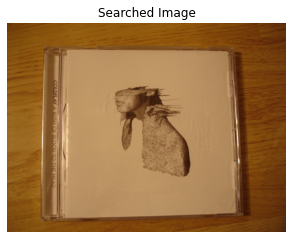

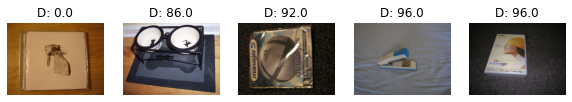

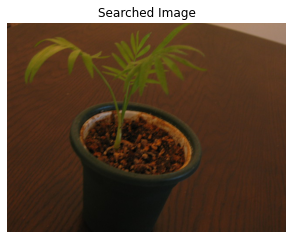

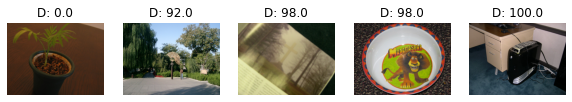

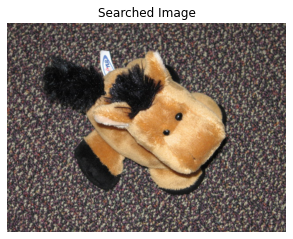

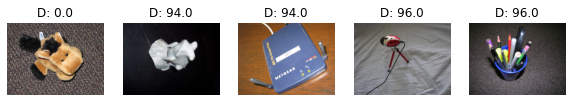

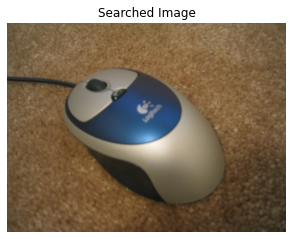

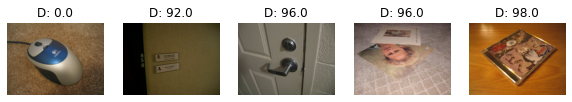

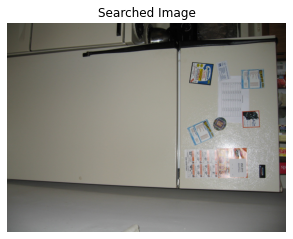

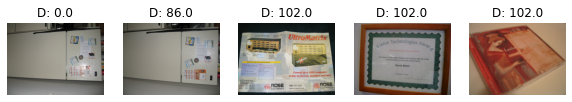

In [11]:
for x in range(len(results)):
    query_file = search_images[x]
    result_files = [red.get(y.id).decode('utf-8') for y in results[x]]
    distances = [y.distance for y in results[x]]
    show_results(query_file, result_files, distances)

## Attribution
This notebook has been adapted from [Reverse image search tutorial](https://github.com/milvus-io/bootcamp/blob/master/solutions/reverse_image_search/reverse_image_search.ipynb) to accommodate image hashes in place of feature vectors.